## **YAP 101 Homework-5**  
Due Date: 17 March 2020 23:59

Send your files to m.torusdag@etu.edu.tr

The subject of your email should be "YAP101 HW5"

In [9]:
# Run this cell first
from datascience import * 
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import numpy as np

**Question 1 (5 Points)**. We want to predict the sale price of houses. Thankfully, we have a data for that. Please load the house.csv data in Resources section on Piazza. In that data, there are 10 columns and one of them is "SalePrice" which is the value we want to predict. First, divide the data into two halves: train and test. First half is the train and the other half is will be used for test.

In [10]:
import pandas as pd
data=pd.read_csv('house.csv')
data=data.select_dtypes(include=['float64','int64'])
data = data.dropna(how='any',axis=0) 
house=Table.from_df(data)
train,test=house.shuffle().split(1137)

In [11]:
train.show(4)

Order,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice
2762,906394040,20,78,9316,7,5,2005,2005,140,56,0,1558,1614,1614,0,0,1614,0,0,2,0,3,1,7,1,2005,2,576,100,45,0,0,0,0,0,3,2006,225000
688,535475010,60,76,7570,6,5,1964,1964,420,0,0,780,780,993,813,0,1806,0,0,1,1,4,1,8,0,1964,2,483,0,55,0,0,0,0,0,3,2009,144750
1281,535475020,60,71,7056,6,5,1963,1963,415,400,0,380,780,983,813,0,1796,1,0,1,1,4,1,8,1,1963,2,483,0,50,0,0,0,0,0,10,2008,140000
189,902402130,70,60,7740,4,7,1910,1950,0,0,0,622,622,741,622,0,1363,0,0,1,0,3,1,6,0,1966,2,528,0,0,0,0,168,0,0,6,2010,125500


**Question 2 (20 Points)** For each column in the table (other than SalePrice column), calculate the pearson correlation with SalePrice **using the train data**. Print each column name and calculated pearson correlation. 

In [12]:
from scipy.stats import pearsonr
len(train.labels)

39

In [13]:
pearsonr_array=make_array()
labels=make_array()
for i in np.arange(len(train.labels)-1):
    r_column=pearsonr(train.column('SalePrice'),train.column(i))[0]
    pearsonr_array=np.append(pearsonr_array,r_column)
    labels=np.append(labels,train.labels[i])
    
pearson_table=Table().with_columns("column_name",labels,"pearson_r",pearsonr_array)
pearson_table

column_name,pearson_r
Order,-0.0734255
PID,-0.239609
MS SubClass,-0.110116
Lot Frontage,0.368816
Lot Area,0.293032
Overall Qual,0.807481
Overall Cond,-0.174109
Year Built,0.569215
Year Remod/Add,0.536344
Mas Vnr Area,0.535879


**Question 3 (10 Points)** For the column that has the highest pearson correlation, calculate the slope and intersept of the linear regression line. 

In [14]:
pearson_table.sort('pearson_r', descending=True).take(0)

column_name,pearson_r
Overall Qual,0.807481


In [15]:
def rmse(slope, intercept):
    y = train.column('SalePrice')
    x = train.column('Overall Qual')
    fitted = slope * x + intercept
    mse = np.mean((y - fitted) ** 2)
    return mse ** 0.5

In [16]:
slope=minimize(rmse)[0]
intercept=minimize(rmse)[1]
slope,intercept

(43759.22129133456, -82644.96735005129)

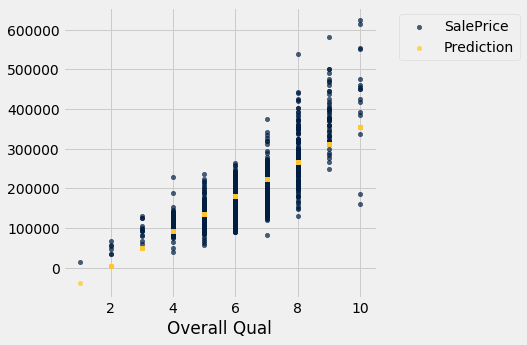

In [17]:
prediction = train.with_column('Prediction',slope*train.column('Overall Qual') + intercept)
prediction.select("Overall Qual", "SalePrice","Prediction").scatter("Overall Qual")


**Question 5(10 Points)**. What is the root mean square error for the regression line?

In [18]:
def rmse(slope, intercept):
    y =prediction.column("SalePrice")
    x =prediction.column("Overall Qual")
    fitted = slope * x + intercept
    mse = np.mean((y - fitted) ** 2)
    return mse ** 0.5

In [19]:
rmse(slope,intercept)

50141.58032798591

**Question 6 (30 Points)** For each column, try to fit a non-linear regression line (ax2 + bx + c) and calculate their rmse scores.

In [20]:
a=make_array()
b=make_array()
c=make_array()
labels=make_array()
rmse_values=make_array()

for i in np.arange(len(train.labels)-1):
    def quadratic_mse(a, b, c):
        x = train.column(i)
        y = train.column('SalePrice')
        fitted =  a*(x**2) + b*x + c
        return np.mean((y - fitted) ** 2)
    minimize_values=minimize(quadratic_mse)
    a=np.append(a,minimize_values[0])
    b=np.append(b,minimize_values[1])
    c=np.append(c,minimize_values[2])
    labels=np.append(labels,train.labels[i])
    rmse_values=np.append(rmse_values,quadratic_mse(minimize_values[0],minimize_values[1],minimize_values[2]))

rmse_train=Table().with_columns("labels",labels,"a",a,"b",b,"c",c,"rmse values",rmse_values)
rmse_train

labels,a,b,c,rmse values
Order,-0.000709446,-5.10716,195055,7.10408e+09
PID,1.33296e-06,-0.000107259,261448,6.73007e+09
MS SubClass,-3.93419,427.618,180310,6.98719e+09
Lot Frontage,-5.83979,2358.58,51799.5,6.05276e+09
Lot Area,3.64641e-05,3.00447,151411,6.48921e+09
Overall Qual,7190.81,-44075.3,167735,2.05403e+09
Overall Cond,-3569.64,27867.4,144983,6.83465e+09
Year Built,0.362538,140.978,-1.5028e+06,4.81013e+09
Year Remod/Add,0.491182,204.242,-2.15582e+06,5.08456e+09
Mas Vnr Area,-0.0367031,275.146,158063,5.08739e+09


**Question 7(10 Points)**. On test set, find rmse value using the linear regression line you found in Question 3 

In [21]:
def predict_sale(x):
    return slope * x + intercept

In [22]:
def column_rmse(t):
    y =t.column("SalePrice")
    x =t.column("Overall Qual")
    fitted = slope * x + intercept
    mse = np.mean((y - fitted) ** 2)
    return mse ** 0.5

In [23]:
test_regression_prediction = test.with_column('Regression Prediction',test.apply(predict_sale,'Overall Qual') )

column_rmse(test_regression_prediction)

49650.72715314241

**Question 8 (10 Points)**. On test set, find rmse value using the non-linear regression line you found in Question 6 with the lowest rmse score.

In [24]:
nonlinear=rmse_train.sort("rmse values",descending=False).take(0)
non_label=nonlinear.column('labels')[0]
non_a=nonlinear.column('a')[0]
non_b=nonlinear.column('b')[0]
non_c=nonlinear.column('c')[0]
nonlinear

labels,a,b,c,rmse values
Overall Qual,7190.81,-44075.3,167735,2.05403e+09


In [25]:
def predict_nonlinear_sale(x):
    return non_a* x*x + non_b*x+non_c

In [26]:
test_nonlinear_prediction=test.with_column('Regression Prediction',test.apply(predict_nonlinear_sale,non_label) )
test_nonlinear_prediction

Order,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice,Regression Prediction
2574,535152070,80,70,8163,5,6,1959,1959,128,748,294,102,1144,1144,0,0,1144,1,0,1,0,3,1,6,1,1959,1,796,86,0,0,0,0,0,0,3,2006,143000,127129
360,527164020,20,58,7250,6,5,1993,1993,45,0,0,1181,1181,1190,0,0,1190,0,0,2,0,3,1,6,1,1993,2,430,0,21,0,0,0,0,0,11,2009,166000,162153
2417,528221100,60,105,15578,6,5,2006,2006,0,0,0,728,728,728,728,0,1456,0,0,2,1,3,1,8,0,2006,2,429,0,0,0,0,0,0,0,5,2006,172785,162153
2679,903231240,30,51,6120,5,7,1925,1950,0,489,0,279,768,1015,0,0,1015,0,0,1,0,3,1,6,0,1925,1,450,0,0,112,0,120,0,620,7,2006,88000,127129
1297,902128150,190,60,10800,6,6,1940,1950,0,590,0,294,884,884,552,0,1436,0,0,2,0,3,2,8,2,1940,2,828,0,0,126,0,0,0,0,5,2008,155000,162153
2915,923226290,160,21,1484,4,4,1972,1972,0,252,0,294,546,546,546,0,1092,0,0,1,1,3,1,5,0,1972,1,253,0,0,0,0,0,0,0,5,2006,79400,106487
2552,534430050,30,60,8550,6,8,1934,1950,0,574,0,242,816,816,0,0,816,1,0,1,0,2,1,4,1,1949,1,240,228,0,40,0,0,0,0,7,2006,129800,162153
1113,528429050,20,75,11957,8,5,2006,2006,53,24,0,1550,1574,1574,0,0,1574,0,0,2,0,3,1,7,1,2006,3,824,144,104,0,0,0,0,0,7,2008,232000,275345
241,905453040,20,83,10420,6,5,2009,2009,0,36,0,1176,1212,1212,0,0,1212,0,0,2,0,3,1,6,0,2009,2,460,100,22,0,0,0,0,0,3,2010,186000,162153
2451,528360050,60,114,17242,9,5,1993,1994,738,292,1393,48,1733,1933,1567,0,3500,1,0,3,1,4,1,11,1,1993,3,959,870,86,0,0,210,0,0,5,2006,584500,353513


In [27]:
def column_rmse_non(t):
    y =t.column("SalePrice")
    x =t.column("Overall Qual")
    fitted = non_a* x*x + non_b*x+non_c
    mse = np.mean((y - fitted) ** 2)
    return mse ** 0.5

In [28]:
column_rmse_non(test_nonlinear_prediction)

44787.7752458498